# Composite figure

In [156]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
import matplotlib.pyplot as plt
import scipy.stats as sts
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import sys
sys.path.insert(0, '.')

from functions import (
    load_cardinal_task_data, load_all_task_data, filter_common_monkeys,
    compute_flat_tuning, cross_task_cv,
    build_representations, procrustes_distance_matrix,
    assign_age_groups, cross_age_analysis, cross_monkey_by_group,
    build_epoch_representations, cross_epoch_distances,
    pooled_tuning_by_group, pca_reduce_tuning,
    tuning_to_matrix, generalized_procrustes,
    load_behavioral_data, behavioral_distance_matrices,
    draw_3d_alignment, draw_cross_task_bars,
    draw_cross_age_bars, draw_cross_monkey_scatter,
    draw_neural_vs_behavior, draw_cross_epoch_vs_behavior,
    draw_correlation_matrices, plot_age_distributions,
    STIM_COLORS, STIM_LABELS, TASK_EPOCHS, TASK_COLORS,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
# ── Paths ─────────────────────────────────────────────────────────────────
DATA_DIR = '../data_raw'
BEH_SAC = '../original_repo/behavior/sac_data.csv'
BEH_SAC_ODRD = '../original_repo/GAM/data/sac_odrd.csv'

# ── Age grouping ──────────────────────────────────────────────────────────
AGE_EDGES = (48, 60)
AGE_GROUP_LABELS = ['young', 'middle', 'old']

# ── PCA / neuron thresholds ──────────────────────────────────────────────
BIN_MS = 25
N_PCS_3D = 4
MIN_NEURONS_3D = N_PCS_3D + 1
N_PCS = 5
MIN_NEURONS = N_PCS + 1
N_PCS_CT = 8
MIN_NEURONS_CT = N_PCS_CT + 1
BIN_MS_CT = 50
N_PCS_CE = 8
MIN_NEURONS_CE = 10
N_AGE_BINS = 3

# ── Panels 4-6: epochs & colors ─────────────────────────────────────────
TASK_LIST = ['ODR 1.5s', 'ODR 3.0s', 'ODRd']
PLOT_EPOCHS = ['cue', 'delay', 'response']
EPOCH_COLORS = {'cue': '#2196F3', 'delay': '#FF9800', 'response': '#9C27B0'}

# ── Panel 7: common epochs for 3-way cross-task ─────────────────────────
COMMON_EPOCHS_CT = {'cue': (0, 500), 'delay': (500, 1700)}
T_RANGES = {'ODR 1.5s': (-1000, 2500), 'ODR 3.0s': (-1000, 3500), 'ODRd': (-1000, 3500)}

# ── Panels 12-14: cross-epoch definitions ───────────────────────────────
CROSS_EPOCH_DEFS = {
    'ODR 1.5s': dict(t_range=(-1000, 2500),
                     epochs={'cue': (0, 500), 'delay': (1250, 2000), 'response': (2000, 2500)}),
    'ODR 3.0s': dict(t_range=(-1000, 3500),
                     epochs={'cue': (0, 500), 'delay': (1750, 3000), 'response': (3000, 3500)}),
    'ODRd':     dict(t_range=(-1000, 4000),
                     epochs={'cue': (0, 500), 'delay': (2200, 3000), 'response': (3000, 3500)}),
}
COMPARISONS = [('cue', 'delay'), ('delay', 'response'), ('cue', 'response')]

In [158]:
cardinal_data = load_cardinal_task_data(DATA_DIR)

task_results = {}
for task_name in TASK_LIST:
    all_epochs = TASK_EPOCHS[task_name]['epochs']
    epochs = {k: all_epochs[k] for k in PLOT_EPOCHS}

    grouped_t, enames = pooled_tuning_by_group(
        {task_name: cardinal_data[task_name]}, epochs, AGE_EDGES, bin_ms=BIN_MS)
    reduced_t = pca_reduce_tuning(grouped_t, n_pcs=N_PCS_3D, min_neurons=MIN_NEURONS_3D)

    all_mats = []
    for mid in sorted(reduced_t.keys()):
        for g in sorted(reduced_t[mid].keys()):
            all_mats.append(tuning_to_matrix(reduced_t[mid][g], n_dims=3))
    aligned_all, grand_mean = generalized_procrustes(all_mats)

    lim = np.max(np.abs(grand_mean)) * 1.6
    task_results[task_name] = dict(aligned_all=aligned_all, grand_mean=grand_mean,
                                   enames=enames, lim=lim)

print('Panels 4-6: per-task alignment computed.')

  neuron 0/1180
  neuron 500/1180
  neuron 1000/1180
  neuron 0/922
  neuron 500/922
  neuron 0/1319
  neuron 500/1319
  neuron 1000/1319
Panels 4-6: per-task alignment computed.


In [159]:
tasks_ct, _ = filter_common_monkeys(cardinal_data)

tuning_flat = {}
for name in tasks_ct:
    flat, _, _ = compute_flat_tuning(tasks_ct[name]['data'], T_RANGES[name], COMMON_EPOCHS_CT, BIN_MS_CT)
    tuning_flat[name] = flat

task_ids = {name: tasks_ct[name]['ids'] for name in tasks_ct}
ct_results = cross_task_cv(tuning_flat, task_ids, N_PCS_CT, MIN_NEURONS_CT, 100, 42)
print('Panel 7: cross-task CV computed.')

  neuron 0/391
  neuron 0/922
  neuron 500/922
  neuron 0/1319
  neuron 500/1319
  neuron 1000/1319
  iteration 25/100
  iteration 50/100
  iteration 75/100
  iteration 100/100
Done.
Panel 7: cross-task CV computed.


In [ ]:
task_data = load_all_task_data(DATA_DIR)

# PSTHs and tuning
psth_data = {}
for name, cfg in TASK_EPOCHS.items():
    flat, rates, bc = compute_flat_tuning(task_data[name]['data'], cfg['t_range'], cfg['epochs'], BIN_MS)
    psth_data[name] = dict(rates=rates, bc=bc, flat=flat)

# Age groups
age_groups = {}
for task_name in task_data:
    age_groups[task_name] = assign_age_groups(task_data[task_name]['abs_age'], AGE_EDGES)

# Panel 8: cross-age results
indiv_results = {}
for task_name in task_data:
    ids = task_data[task_name]['ids']
    tuning = psth_data[task_name]['flat']
    ag = age_groups[task_name]
    entries = build_representations(tuning, ids, ag, n_pcs=N_PCS, min_neurons=MIN_NEURONS, zscore=True)
    dist = procrustes_distance_matrix(entries)
    ca = cross_age_analysis(entries, dist)
    indiv_results[task_name] = dict(entries=entries, dist=dist, cross_age=ca)

print('Panel 8: cross-age computed.')

# Panel 9: cross-monkey by group
results_by_group, pooled = cross_monkey_by_group(
    task_data, psth_data, age_groups, N_PCS, MIN_NEURONS, AGE_GROUP_LABELS)

print('Panel 9: cross-monkey by group computed.')

  neuron 0/1180
  neuron 500/1180
  neuron 1000/1180
  neuron 0/922
  neuron 500/922
  neuron 0/1319
  neuron 500/1319
  neuron 1000/1319
Panel 8: cross-age computed.


TypeError: cross_monkey_by_group() got an unexpected keyword argument 'method'

In [161]:
beh_df = load_behavioral_data(BEH_SAC, sac_odrd_path=BEH_SAC_ODRD)

beh_dist = {}
for task_name in indiv_results:
    R = indiv_results[task_name]
    di_dist, rt_dist, di_vals, rt_vals = behavioral_distance_matrices(
        beh_df, R['entries'], AGE_EDGES, task_name)
    beh_dist[task_name] = dict(di_dist=di_dist, rt_dist=rt_dist,
                               di_vals=di_vals, rt_vals=rt_vals)

print('Panels 10-11: behavioral distances computed.')

Panels 10-11: behavioral distances computed.


In [162]:
epoch_reps, ce_age_groups, monkey_edges = build_epoch_representations(
    task_data, CROSS_EPOCH_DEFS, N_PCS_CE, MIN_NEURONS_CE, bin_ms=BIN_MS, n_age_bins=N_AGE_BINS)
cross_epoch = cross_epoch_distances(epoch_reps, COMPARISONS)

print('Panels 12-14: cross-epoch distances computed.')

  neuron 0/1180
  neuron 500/1180
  neuron 1000/1180
  neuron 0/922
  neuron 500/922
  neuron 0/1319
  neuron 500/1319
  neuron 1000/1319
Panels 12-14: cross-epoch distances computed.


Saved to figures/figure_composite.pdf and .svg


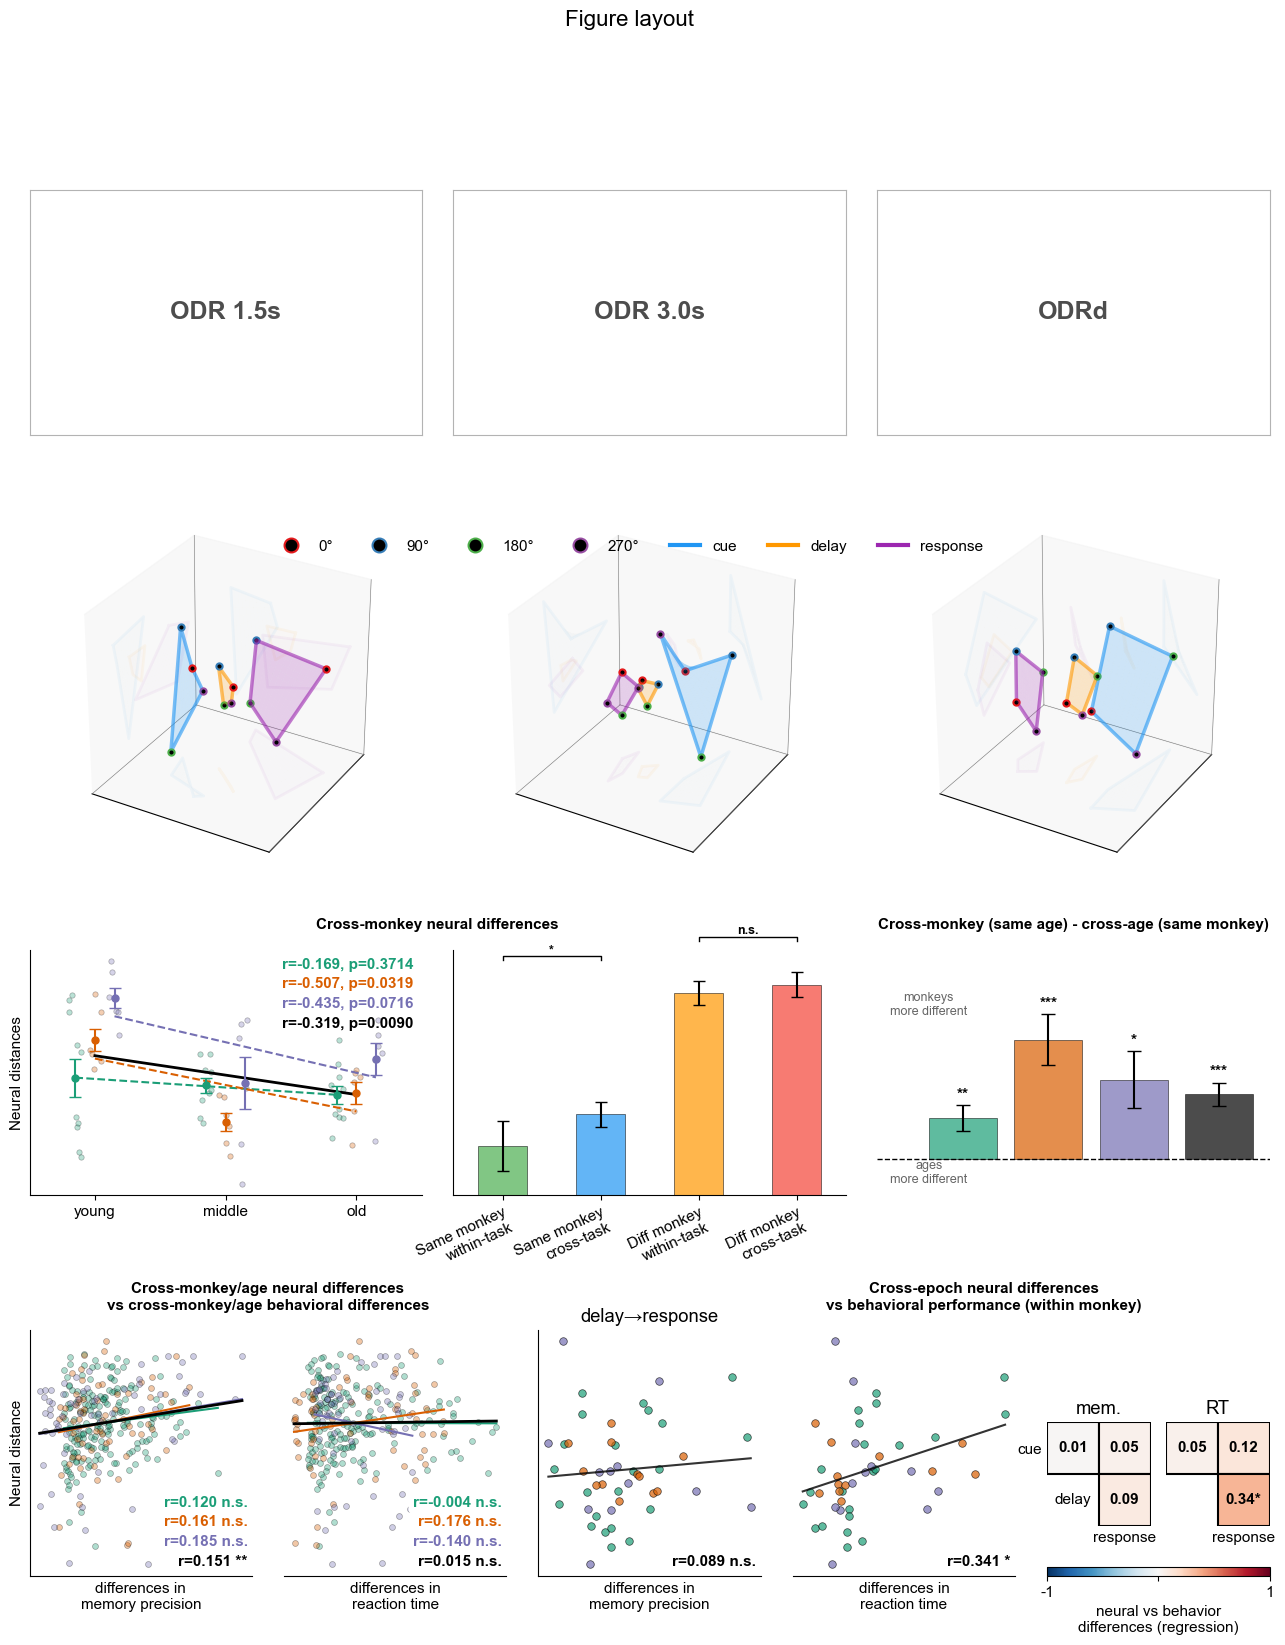

In [163]:
n_conds = 4

plt.rcParams.update({'font.size': 11})

fig = plt.figure(figsize=(16, 18))
gs = GridSpec(4, 15, figure=fig, hspace=0.55, wspace=0.6)

panels = []

# Row 1: panels 0-2 (each spans 5 of 15 cols)
for col in range(3):
    panels.append(fig.add_subplot(gs[0, col*5:(col+1)*5]))

# Row 2: panels 3-5 (3D per-task alignment)
for col in range(3):
    panels.append(fig.add_subplot(gs[1, col*5:(col+1)*5], projection='3d'))

# Row 3: panels 6-8
for col in range(3):
    panels.append(fig.add_subplot(gs[2, col*5:(col+1)*5]))

# Row 4: panels 9-12 only (panel 13 slot reserved for correlation matrices)
for col in range(4):
    panels.append(fig.add_subplot(gs[3, col*3:(col+1)*3]))

# ── Expand 3D panels to fill their space ─────────────────────────────────
for idx in (3, 4, 5):
    pos = panels[idx].get_position()
    expand = 1.4
    w, h = pos.width * expand, pos.height * expand
    cx, cy = pos.x0 + pos.width / 2, pos.y0 + pos.height / 2
    panels[idx].set_position([cx - w/2, cy - h/2, w, h])

# ── Panels 1-3: task labels ──────────────────────────────────────────────
for i, task_name in enumerate(TASK_LIST):
    ax = panels[i]
    ax.text(0.5, 0.5, task_name, transform=ax.transAxes,
            fontsize=18, fontweight='bold', ha='center', va='center', color='0.3')
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor('0.7')

# ── Panels 4-6: per-task 3D alignment ────────────────────────────────────
ROTATIONS = {'ODR 1.5s': (0, 0, 60), 'ODR 3.0s': (0, 45, 45)}
for col, task_name in enumerate(TASK_LIST):
    rot = ROTATIONS.get(task_name, (0, 0, 0))
    draw_3d_alignment(panels[3 + col], task_results[task_name],
                      PLOT_EPOCHS, EPOCH_COLORS, STIM_COLORS, n_conds,
                      rotation=rot)

# Legend for panels 4-6
dir_handles = [Line2D([0], [0], marker='o', color='w',
                       markerfacecolor='k', markeredgecolor=c,
                       markeredgewidth=1.5, markersize=10, label=l)
               for c, l in zip(STIM_COLORS, STIM_LABELS)]
epoch_handles = [Line2D([0], [0], color=EPOCH_COLORS[e], lw=3, label=e)
                 for e in PLOT_EPOCHS]
fig.legend(handles=dir_handles + epoch_handles,
           loc='lower center', ncol=len(STIM_COLORS) + len(PLOT_EPOCHS),
           frameon=False, bbox_to_anchor=(0.5, 0.67))

# ── Panel 7: cross-monkey by group ──────────────────────────────────────
draw_cross_monkey_scatter(panels[6], results_by_group, pooled, AGE_GROUP_LABELS, TASK_COLORS)
panels[6].set_xlim(-0.5, len(AGE_GROUP_LABELS) - 0.5)

# ── Panel 8: cross-task bar plot ─────────────────────────────────────────
draw_cross_task_bars(panels[7], ct_results)
panels[7].set_xlim(-0.5, len(ct_results['cat_names']) - 0.5)

# ── Shared title: panels 7 & 8 ──────────────────────────────────────────
p6 = panels[6].get_position()
p7 = panels[7].get_position()
fig.text((p6.x0 + p7.x1) / 2, p6.y1 + 0.01,
         'Cross-monkey neural differences',
         ha='center', va='bottom', fontsize=11, fontweight='bold')

# ── Panel 9: cross-age bar plot ──────────────────────────────────────────
draw_cross_age_bars(panels[8], indiv_results, TASK_COLORS)
panels[8].set_xticks([]); panels[8].set_xlabel('')

# ── Title: panel 9 ──────────────────────────────────────────────────────
p8 = panels[8].get_position()
fig.text((p8.x0 + p8.x1) / 2, p8.y1 + 0.01,
         'Cross-monkey (same age) - cross-age (same monkey)',
         ha='center', va='bottom', fontsize=11, fontweight='bold')

# ── Panels 10-11: neural vs DI / RT ─────────────────────────────────────
draw_neural_vs_behavior(panels[9], indiv_results, beh_dist, 'di_dist', TASK_COLORS,
                        xlabel='differences in\nmemory precision')
draw_neural_vs_behavior(panels[10], indiv_results, beh_dist, 'rt_dist', TASK_COLORS,
                        xlabel='differences in\nreaction time', show_ylabel=False, show_left_spine=False)

# ── Shared title: panels 10 & 11 ────────────────────────────────────────
p9 = panels[9].get_position()
p10 = panels[10].get_position()
fig.text((p9.x0 + p10.x1) / 2, p9.y1 + 0.01,
         'Cross-monkey/age neural differences\nvs cross-monkey/age behavioral differences',
         ha='center', va='bottom', fontsize=11, fontweight='bold')

# ── Panels 12-13: cross-epoch DI/RT vs neural distance delay→resp. ──────
ce_label = 'delay\u2192response'
draw_cross_epoch_vs_behavior(panels[11], cross_epoch, CROSS_EPOCH_DEFS, beh_df, monkey_edges,
                             ce_label, 'DI', TASK_COLORS,
                             xlabel='differences in\nmemory precision',
                             title='delay\u2192response')
draw_cross_epoch_vs_behavior(panels[12], cross_epoch, CROSS_EPOCH_DEFS, beh_df, monkey_edges,
                             ce_label, 'RT', TASK_COLORS,
                             xlabel='differences in\nreaction time',
                             show_left_spine=False)

# ── Panel 14: correlation matrices ───────────────────────────────────────
pairs_14 = [('cue', 'delay'), ('cue', 'response'), ('delay', 'response')]
pos_map = {0: (0, 0), 1: (0, 1), 2: (1, 1)}
draw_correlation_matrices(fig, gs[3, 12:15], cross_epoch, CROSS_EPOCH_DEFS,
                          beh_df, monkey_edges, pairs_14, pos_map)

# ── Shared title: panels 12, 13 & 14 ────────────────────────────────────
p11_ = panels[11].get_position()
p12_ = panels[12].get_position()
fig.text((p11_.x0 + 1.0) / 2, p11_.y1 + 0.01,
         'Cross-epoch neural differences\nvs behavioral performance (within monkey)',
         ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle('Figure layout', fontsize=16, y=0.98)

fig.savefig('figures/figure_composite.pdf', bbox_inches='tight', dpi=300)
fig.savefig('figures/figure_composite.svg', bbox_inches='tight', dpi=300)
print('Saved to figures/figure_composite.pdf and .svg')